# Tranfer Learnning to Flower Recognition using PyTorch 🔥
This dataset contains labeled 4242 images of flowers.


### Content
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Data
You can download data from: [Flowers Recognition Dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

In [ ]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od

In [ ]:

dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition/flowers'
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: santiches
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:02<00:00, 88.4MB/s]


In [ ]:
import os

# Look into the data directory
root_dir = './flowers-recognition'
data_dir = './flowers-recognition/flowers'
print(os.listdir(data_dir))

['sunflower', 'rose', 'daisy', 'tulip', 'dandelion']


In [ ]:
def rename_files(root_dir):
    classes = os.listdir(root_dir)
    for classes in classes:
        for file in os.listdir(root_dir + '/' + classes):
            if file.endswith('jpg'):
                os.rename((root_dir + '/' + classes + '/' + file),(root_dir + '/' + classes + '/' + classes + "_" + file))

rename_files(data_dir)

In [ ]:
#import os
from torch.utils.data import Dataset
from PIL import Image

def parse_species(fname):
    parts = fname.split('_')
    return parts[0]

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.files = []
        self.classes = [fname for fname in os.listdir(root_dir) if fname != 'flowers']
        for classes in self.classes:
            for file in os.listdir(root_dir + '/' + classes):
                if file.endswith('jpg'):
                    self.files.append(file)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        species = parse_species(fname)
        fpath = os.path.join(self.root_dir, species, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(species)
        return img, class_idx

In [ ]:
import torchvision.transforms as T

img_size = 128
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.224))
transform = T.Compose([T.Resize((img_size, img_size)),
                       T.RandomCrop(128, padding=4, padding_mode='constant'),
                       T.RandomHorizontalFlip(),
                       T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       T.ToTensor(),
                       T.Normalize(*stats,inplace=True)])
dataset = FlowersDataset(data_dir, transform=transform)

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(3,1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
print(*dataset[1746][0].shape)

3 128 128


In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).view(3, 1, 1)  # Cambia la forma a (3, 1, 1)
    stds = torch.tensor(stds).view(3, 1, 1)    # Cambia la forma a (3, 1, 1)
    return images * stds + means


Label: daisy (2)


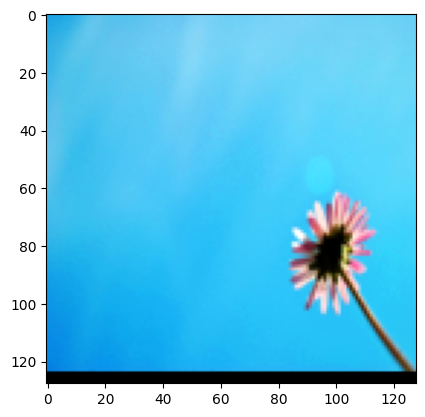

In [ ]:
show_image(*dataset[1749]);

In [ ]:
from torch.utils.data import random_split

random_seed = 55
torch.manual_seed(random_seed)

val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [ ]:
len(dataset)

4317

In [ ]:
train_ds, valid_ds= random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, num_workers=3, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(batch_size, dl):
    for images, labels in dl:
        batch_size = 128
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
len(valid_dl)

431

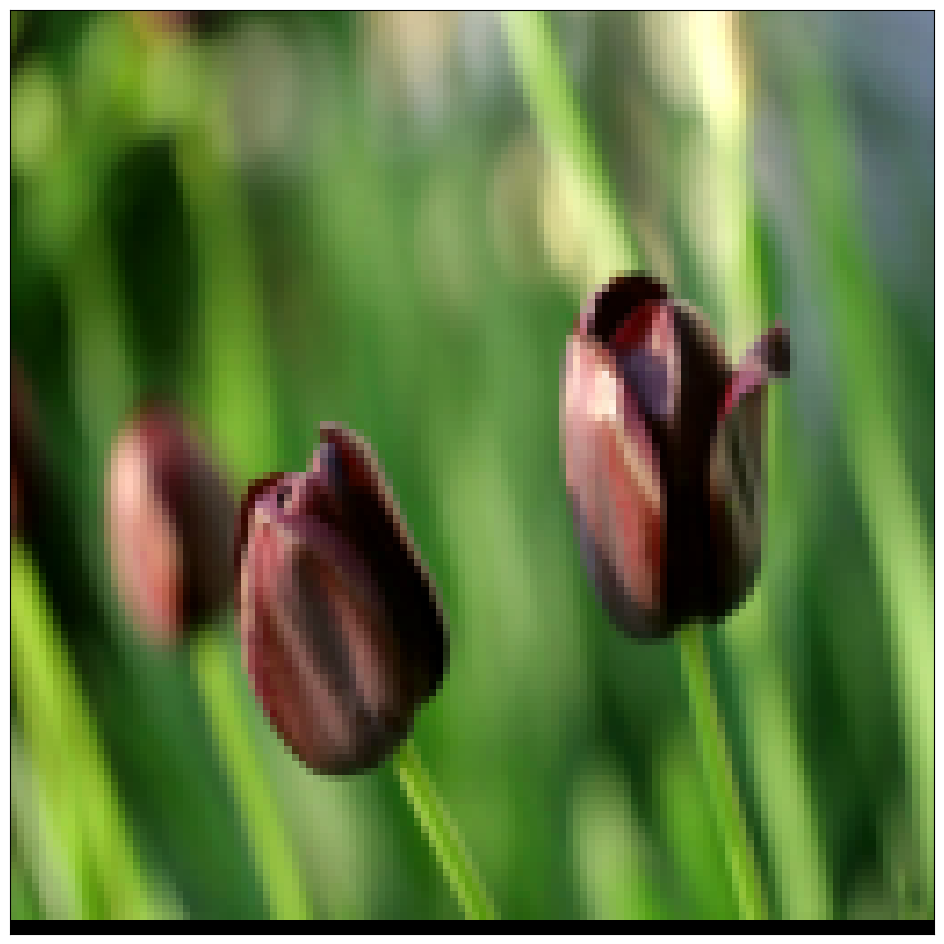

In [ ]:
show_batch(12, train_dl)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if batch % 100 == 0:
            #loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    #test_loss /= num_batches
    #correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3) # Ajustado padding
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=128)  # Ajusta el tamaño de in_features
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=5)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # Print shape
        print("Shape after conv layers:", x.shape)
        # Flatten the output
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # Output layer
        x = self.fc3(x)
        return x

In [ ]:
# Instantiate and print the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    test(valid_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Shape after conv layers: torch.Size([1, 128, 32, 32])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x131072 and 8192x128)